In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.


In [20]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import tensorflow
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

In [5]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

benign = np.array(Dataset_loader('drive/MyDrive/Breast Cancer Data/Breast+Cancer+Dataset+Small+-partial-/benign',224))
malign = np.array(Dataset_loader('drive/MyDrive/Breast Cancer Data/Breast+Cancer+Dataset+Small+-partial-/malign',224))

100%|██████████| 127/127 [00:05<00:00, 22.98it/s]


In [6]:
benign_label = np.zeros(len(benign))
malign_label = np.ones(len(malign))

In [14]:
X = np.concatenate((benign, malign), axis = 0)
Y = np.concatenate((benign_label, malign_label), axis = 0)

In [28]:
X[0].shape

(224, 224, 3)

In [16]:
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]



In [17]:
Y

array([1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 1., 1.

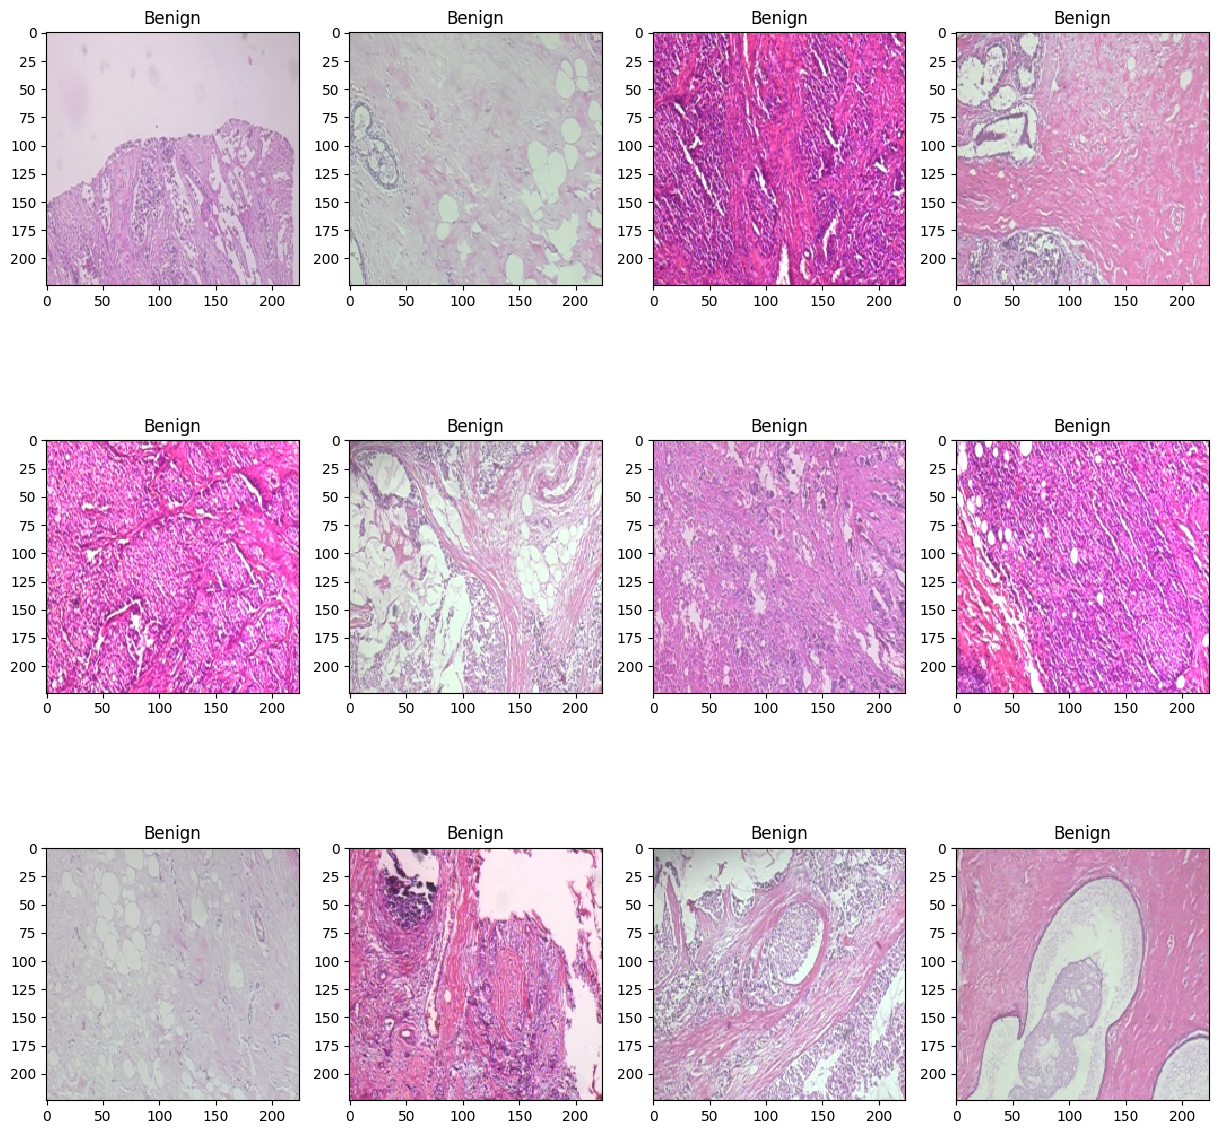

In [18]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [25]:
x_val

array([[[[199, 155, 182],
         [196, 154, 184],
         [199, 161, 184],
         ...,
         [204, 183, 193],
         [185, 148, 173],
         [188, 152, 184]],

        [[199, 153, 181],
         [197, 149, 183],
         [209, 163, 197],
         ...,
         [206, 185, 197],
         [177, 142, 166],
         [185, 156, 183]],

        [[196, 148, 175],
         [195, 142, 177],
         [203, 150, 186],
         ...,
         [196, 177, 189],
         [162, 132, 155],
         [184, 159, 179]],

        ...,

        [[175, 140, 165],
         [185, 151, 179],
         [186, 151, 178],
         ...,
         [216, 140, 182],
         [224, 152, 195],
         [206, 149, 189]],

        [[201, 167, 187],
         [201, 163, 192],
         [212, 171, 205],
         ...,
         [218, 145, 186],
         [219, 150, 191],
         [211, 154, 196]],

        [[217, 182, 202],
         [215, 177, 207],
         [210, 170, 203],
         ...,
         [217, 144, 189],
        

In [29]:
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#second convolution
model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#third convlolution
model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

#convert the data into 1-d array
model.add(Flatten())

#adding first hidden layer with 128 neurons and realu activation
model.add(Dense(128,activation='relu'))
#adding second hidden layer with 64 neurons and relu activation
model.add(Dense(64,activation='relu'))
#here we have a 1 output since it is a binary classification
model.add(Dense(1,activation='sigmoid'))



In [30]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
model.fit(x_train,y_train,epochs=5)

Epoch 1/5
6/6 [==============================] - 27s 4s/step - loss: 405.8239 - accuracy: 0.4817
Epoch 2/5
6/6 [==============================] - 23s 4s/step - loss: 4.7367 - accuracy: 0.5916
Epoch 3/5
6/6 [==============================] - 22s 4s/step - loss: 0.7584 - accuracy: 0.7644
Epoch 4/5
6/6 [==============================] - 25s 4s/step - loss: 0.3801 - accuracy: 0.8429
Epoch 5/5
6/6 [==============================] - 26s 4s/step - loss: 0.2869 - accuracy: 0.8743


In [33]:
import pickle

pickle.dump(model, open('drive/MyDrive/Breast Cancer Data/Breast+Cancer+Dataset+Small+-partial-/image-generator-model.pkl', 'wb'))
model.save('drive/MyDrive/Breast Cancer Data/Breast+Cancer+Dataset+Small+-partial-/breast-cancer-model.h5')

In [44]:
p1=plt.imread(r"/content/SOB_B_A-14-22549AB-40-026.png")

In [47]:
import cv2
p1=cv2.resize(p1,(224,224))

In [48]:
p1.shape

(224, 224, 3)

In [49]:
p1=p1.reshape((1,224,224,3))

In [50]:
pred=model.predict(p1)

1/1 [==============================] - 0s 213ms/step


In [55]:
print('probability of breast cancer is', pred[0][0])

probability of breast cancer is 0.49719676


In [56]:
p2=plt.imread(r"/content/SOB_M_DC-14-2773-40-016.png")
import cv2
p2=cv2.resize(p2,(224,224))
p2=p2.reshape((1,224,224,3))
pred=model.predict(p2)
print('probability of breast cancer is', pred[0][0])

1/1 [==============================] - 0s 114ms/step
probability of breast cancer is 0.5033094


In [58]:
p1=plt.imread(r"/content/SOB_B_A-14-22549AB-40-026.png")
import cv2
p1=cv2.resize(p1,(224,224))
p1=p1.reshape((1,224,224,3))
pred=model.predict(p1)
print('probability of breast cancer is', pred[0][0])

1/1 [==============================] - 0s 224ms/step
probability of breast cancer is 0.49719676
